<a href="https://colab.research.google.com/github/Akshat13shah/STT_Ass1/blob/main/STT_CSE_Ass_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install radon

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 4.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd

# Load processed CSV
output_csv = "/content/drive/MyDrive/STT_CSE/ass3.csv"
df = pd.read_csv(output_csv)

# Show only the new metric columns
new_cols = [
    'MI_Before','MI_After','CC_Before','CC_After','LOC_Before','LOC_After',
    'MI_Change','CC_Change','LOC_Change'
]

print("✅ New columns added:\n")
print(df[new_cols].head(20))  # show first 20 rows

print("\n📊 Column-wise summary:")
print(df[new_cols].describe(include='all'))

part c

In [ ]:
import pandas as pd
import sys
import os
import time
from radon.metrics import mi_visit
from radon.complexity import cc_visit
from radon.raw import analyze
from multiprocessing import Pool, TimeoutError

# ========================
# Config
# ========================
INPUT_CSV = "/content/drive/MyDrive/STT_CSE/rectified_final.csv"
OUTPUT_CSV = "/content/drive/MyDrive/STT_CSE/mi_cc_loc_ass3.csv"
PYTHON_ONLY = True
ADD_CLEANED_COLUMNS = True
RADON_TIMEOUT = 30  # seconds to wait for radon analysis
SAVE_EVERY = 50     # ✅ save results every N rows

# ========================
# Helpers
# ========================
def clean_code(snippet: str) -> str:
    """Remove diff/patch markers and conflict junk from code snippet."""
    if not isinstance(snippet, str):
        return ""
    lines = []
    for line in snippet.splitlines():
        if line.strip().startswith(("+", "-", "@@", "<<<", ">>>", "===")):
            continue
        lines.append(line)
    return "\n".join(lines)

def safe_get_code(x):
    return "" if pd.isna(x) else str(x)

def looks_like_python(filename: str, snippet: str) -> bool:
    """Check if file is probably Python."""
    if filename.endswith(".py"):
        return True
    return "def " in snippet or "class " in snippet

def analyze_code_with_radon(snippet: str):
    """Wrapper to safely run radon and handle unexpected failures."""
    if not snippet.strip():
        return None, None, None
    try:
        mi = mi_visit(snippet, True)
    except Exception:
        mi = None
    try:
        cc = sum([b.complexity for b in cc_visit(snippet)])
    except Exception:
        cc = None
    try:
        loc = analyze(snippet).loc
    except Exception:
        loc = None
    return mi, cc, loc

# ========================
# Main
# ========================
try:
    df = pd.read_csv(INPUT_CSV)
except FileNotFoundError:
    print(f"Error: The file '{INPUT_CSV}' was not found.")
    sys.exit(1)

total = len(df)
skipped_non_py = 0
skipped_errors = 0
mi_computed = 0

# Add new metric columns if they don't exist, initializing them with floats
for col in ["MI_Before","MI_After","MI_Change",
            "CC_Before","CC_After","CC_Change",
            "LOC_Before","LOC_After","LOC_Change"]:
    if col not in df.columns:
        df[col] = 0.0

pool = Pool(processes=4)  # Use a pool of processes

for idx, row in df.iterrows():
    try:
        filename = str(row.get("Filename", "") or "")
        raw_before = safe_get_code(row.get("Source Before", ""))
        raw_after = safe_get_code(row.get("Source Current", ""))

        if PYTHON_ONLY and not looks_like_python(filename, raw_before + raw_after):
            skipped_non_py += 1
            continue

        cleaned_before = clean_code(raw_before)
        cleaned_after = clean_code(raw_after)

        # Use multiprocessing with a timeout for analysis
        try:
            async_before = pool.apply_async(analyze_code_with_radon, (cleaned_before,))
            mi_b, cc_b, loc_b = async_before.get(timeout=RADON_TIMEOUT)
        except TimeoutError:
            print(f"\nAnalysis for file '{filename}' (before) timed out.")
            mi_b, cc_b, loc_b = None, None, None
            skipped_errors += 1
        except Exception:
            mi_b, cc_b, loc_b = None, None, None
            skipped_errors += 1

        try:
            async_after = pool.apply_async(analyze_code_with_radon, (cleaned_after,))
            mi_a, cc_a, loc_a = async_after.get(timeout=RADON_TIMEOUT)
        except TimeoutError:
            print(f"\nAnalysis for file '{filename}' (after) timed out.")
            mi_a, cc_a, loc_a = None, None, None
            skipped_errors += 1
        except Exception:
            mi_a, cc_a, loc_a = None, None, None
            skipped_errors += 1

        df.at[idx, "MI_Before"] = mi_b
        df.at[idx, "MI_After"] = mi_a
        df.at[idx, "CC_Before"] = cc_b
        df.at[idx, "CC_After"] = cc_a
        df.at[idx, "LOC_Before"] = loc_b
        df.at[idx, "LOC_After"] = loc_a

        if mi_b is not None and mi_a is not None:
            df.at[idx, "MI_Change"] = mi_a - mi_b
            mi_computed += 1
        if cc_b is not None and cc_a is not None:
            df.at[idx, "CC_Change"] = cc_a - cc_b
        if loc_b is not None and loc_a is not None:
            df.at[idx, "LOC_Change"] = loc_a - loc_b

    except Exception:
        print(f"\nSkipping row {idx+1} due to an unexpected error.")
        skipped_errors += 1
        continue

    # ✅ Save progress every N rows
    if (idx + 1) % SAVE_EVERY == 0:
        df.to_csv(OUTPUT_CSV, index=False)

    sys.stdout.write(
        f"\rProcessed {idx+1}/{total} | Skipped Non-Py: {skipped_non_py} | Skipped Errors: {skipped_errors} | MI Done: {mi_computed}"
    )
    sys.stdout.flush()

# Final save
df.to_csv(OUTPUT_CSV, index=False)

pool.close()
pool.join()

print("\n✅ Done! Final results saved.")
print(f"Saved results to {OUTPUT_CSV}")


Processed 1241/6100 | Skipped Non-Py: 220 | Skipped Errors: 0 | MI Done: 887
Analysis for file 'Features_0.csv' (before) timed out.
Processed 1244/6100 | Skipped Non-Py: 222 | Skipped Errors: 1 | MI Done: 887
Analysis for file 'Features_1.csv' (before) timed out.
Processed 1245/6100 | Skipped Non-Py: 222 | Skipped Errors: 2 | MI Done: 887
Analysis for file 'Features_2.csv' (before) timed out.
Processed 1246/6100 | Skipped Non-Py: 222 | Skipped Errors: 3 | MI Done: 887
Analysis for file 'Features_0.csv' (before) timed out.

Analysis for file 'Features_0.csv' (after) timed out.
Processed 1248/6100 | Skipped Non-Py: 223 | Skipped Errors: 5 | MI Done: 887
Analysis for file 'test_tabular_data.py' (before) timed out.

Analysis for file 'test_tabular_data.py' (after) timed out.
Processed 1249/6100 | Skipped Non-Py: 223 | Skipped Errors: 7 | MI Done: 887
Analysis for file 's3_storage.py' (before) timed out.

Analysis for file 's3_storage.py' (after) timed out.
Processed 1250/6100 | Skipped Non

In [ ]:
# number of unique values
df["Hash"].nunique()


2229

In [ ]:
import pandas as pd


# Show only the new metric columns
new_cols = [
    'MI_Before','MI_After','CC_Before','CC_After','LOC_Before','LOC_After',
    'MI_Change','CC_Change','LOC_Change'
]

print("✅ New columns added:\n")
print(df[new_cols])  # show first 20 rows

print("\n📊 Column-wise summary:")
print(df[new_cols].describe(include='all'))

✅ New columns added:

       MI_Before    MI_After  CC_Before  CC_After  LOC_Before  LOC_After  \
0       0.000000    0.000000        0.0       0.0         0.0        0.0   
1      61.701053   61.701053       18.0      18.0       123.0      123.0   
2      65.168767   65.168767       18.0      18.0        69.0       69.0   
3       0.000000    0.000000        0.0       0.0         0.0        0.0   
4     100.000000  100.000000        1.0       5.0         4.0       20.0   
...          ...         ...        ...       ...         ...        ...   
6095    0.000000    0.000000      758.0     758.0      3444.0     3444.0   
6096    9.607790    9.607790      138.0     138.0       497.0      497.0   
6097    0.000000    0.000000      491.0     494.0      1161.0     1166.0   
6098    0.000000    0.000000        0.0       0.0         0.0        0.0   
6099    0.000000    0.000000        0.0       0.0         0.0        0.0   

      MI_Change  CC_Change  LOC_Change  
0           0.0        0

# part d


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

df="/content/drive/MyDrive/STT_CSE/mi_cc_loc_ass3.csv"
df=pd.read_csv(df)

In [ ]:
df

,Hash,Message,Filename,Source Before,Source Current,Diff,Fix Type,Rectified Message,MI_Before,MI_After,MI_Change,CC_Before,CC_After,CC_Change,LOC_Before,LOC_After,LOC_Change
0,268676b42215080ca3a6be283082f3e02de4eb64,fix pip upload,publish_pip.sh,rm -rf dist hub_array.egg-info\npython3 setup....,rm -rf dist hub.egg-info\npython3 setup.py sdi...,"@@ -1,3 +1,3 @@\n-rm -rf dist hub_array.egg-in...",remove missing dist-info,remove missing dist-info in publish_pip.sh,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,11616dbf1a0fec14ead2cbe531059ae50f101f2c,bugfixes,interface.py,"from bbox import Bbox, chunknames, shade, Vec,...","from bbox import Bbox, chunknames, shade, Vec,...","@@ -44,7 +44,7 @@ class TensorInterface(object...",add missing docstrings,add missing docstrings in interface.py,61.701053,61.701053,0.0,18.0,18.0,0.0,123.0,123.0,0.0
2,11616dbf1a0fec14ead2cbe531059ae50f101f2c,bugfixes,storage.py,import boto3\nimport botocore\nimport tenacity...,import boto3\nimport botocore\nimport tenacity...,"@@ -39,7 +39,7 @@ class S3(Storage):\n ...",add retry to s3_object_list,add retry to s3_object_list in storage.py,65.168767,65.168767,0.0,18.0,18.0,0.0,69.0,69.0,0.0
3,031952c238e056341ac483f40c2c14633e4764ed,exception handling,docker-compose.yaml,version: '2'\n\nservices:\n hub:\n build:\...,version: '2'\n\nservices:\n test:\n build:...,"@@ -1,15 +1,14 @@\n version: '2'\n \n services...",add missing line after hub array,add missing line after hub array in docker-com...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,031952c238e056341ac483f40c2c14633e4764ed,exception handling,exceptions.py,"\nclass OutOfBoundsError(Exception):\n """"""R...","\nclass OutOfBoundsError(Exception):\n """"""R...","@@ -1,4 +1,20 @@\n \n class OutOfBoundsError(E...",add missing docstring,add missing docstring in exceptions.py,100.000000,100.000000,0.0,1.0,5.0,4.0,4.0,20.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6095,e3f11a8b5bd5f9b21dda3837db7fcde304e20a50,minor changes,chunk_engine.py,from collections import OrderedDict\nfrom deep...,from collections import OrderedDict\nfrom deep...,"@@ -838,26 +838,27 @@ class ChunkEngine:\n ...",add missing docstrings,add missing docstrings in chunk_engine.py,0.000000,0.000000,0.0,758.0,758.0,0.0,3444.0,3444.0,0.0
6096,e3f11a8b5bd5f9b21dda3837db7fcde304e20a50,minor changes,test_indra_dataset.py,import deeplake\nimport numpy as np\nfrom deep...,import deeplake\nimport numpy as np\nfrom deep...,"@@ -17,7 +17,7 @@ def test_indexing(local_auth...",add tests for the new example,add tests for the new example in test_indra_da...,9.607790,9.607790,0.0,138.0,138.0,0.0,497.0,497.0,0.0
6097,e3f11a8b5bd5f9b21dda3837db7fcde304e20a50,minor changes,exceptions.py,import requests\nimport numpy as np\nfrom typi...,import requests\nimport numpy as np\nfrom typi...,"@@ -1159,3 +1159,8 @@ class InvalidAuthContext...",add missing docstring,add missing docstring in exceptions.py,0.000000,0.000000,0.0,491.0,494.0,3.0,1161.0,1166.0,5.0
6098,8ade86587d8a94a8d0f1372792d2150c9ddce761,Fixed readme links (#2975),README.md,"<img src=""https://static.scarf.sh/a.png?x-pxid...","<img src=""https://static.scarf.sh/a.png?x-pxid...","@@ -71,16 +71,16 @@ pip install deeplake\n \n ...",add missing docs,add missing docs in README.md,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
import pandas as pd


# Show only the new metric columns
new_cols = [
    'MI_Before','MI_After','CC_Before','CC_After','LOC_Before','LOC_After',
    'MI_Change','CC_Change','LOC_Change'
]

print("✅ New columns added:\n")
print(df[new_cols])  # show first 20 rows

print("\n📊 Column-wise summary:")
print(df[new_cols].describe(include='all'))

✅ New columns added:

       MI_Before    MI_After  CC_Before  CC_After  LOC_Before  LOC_After  \
0       0.000000    0.000000        0.0       0.0         0.0        0.0   
1      61.701053   61.701053       18.0      18.0       123.0      123.0   
2      65.168767   65.168767       18.0      18.0        69.0       69.0   
3       0.000000    0.000000        0.0       0.0         0.0        0.0   
4     100.000000  100.000000        1.0       5.0         4.0       20.0   
...          ...         ...        ...       ...         ...        ...   
6095    0.000000    0.000000      758.0     758.0      3444.0     3444.0   
6096    9.607790    9.607790      138.0     138.0       497.0      497.0   
6097    0.000000    0.000000      491.0     494.0      1161.0     1166.0   
6098    0.000000    0.000000        0.0       0.0         0.0        0.0   
6099    0.000000    0.000000        0.0       0.0         0.0        0.0   

      MI_Change  CC_Change  LOC_Change  
0           0.0        0

In [ ]:
import torch
import pandas as pd
from transformers import RobertaTokenizer, RobertaModel
from sklearn.metrics.pairwise import cosine_similarity
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from tqdm import tqdm
import os

# === Load your dataframe ===
save_path = "/content/drive/MyDrive/STT_CSE/partd_ass3.csv"

if os.path.exists(save_path):
    df = pd.read_csv(save_path)
    print(f"Resuming from saved file: {save_path}")
else:
    # use your df from part c
    print("Starting fresh from part c df")
    #  Make sure `df` already exists in memory from part c before running this!
    # Otherwise load it like: df = pd.read_csv("/content/drive/MyDrive/STT_CSE/partc.csv")

# Load CodeBERT with GPU support
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base")
model = RobertaModel.from_pretrained("microsoft/codebert-base").to(device)

# Get embedding
def get_embedding(code_snippet):
    inputs = tokenizer(str(code_snippet), return_tensors="pt", truncation=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).cpu().numpy()

# Semantic similarity
def compute_semantic_similarity(before, after):
    emb_before = get_embedding(before)
    emb_after = get_embedding(after)
    return float(cosine_similarity(emb_before, emb_after)[0][0])

# BLEU similarity
def compute_bleu(before, after):
    reference = str(before).split()
    candidate = str(after).split()
    smoothie = SmoothingFunction().method4
    return float(sentence_bleu([reference], candidate, smoothing_function=smoothie))

# Add new columns if missing
if "Semantic_Similarity" not in df.columns:
    df["Semantic_Similarity"] = None
if "Token_Similarity" not in df.columns:
    df["Token_Similarity"] = None

# Process rows with tqdm + resume support
for idx, row in tqdm(df.iterrows(), total=len(df)):
    if pd.isna(row["Semantic_Similarity"]) or pd.isna(row["Token_Similarity"]):
        try:
            df.at[idx, "Semantic_Similarity"] = compute_semantic_similarity(row["Source Before"], row["Source Current"])
            df.at[idx, "Token_Similarity"] = compute_bleu(row["Source Before"], row["Source Current"])
        except Exception as e:
            print(f"Error at row {idx}: {e}")

        # Save progress every 50 rows
        if idx % 50 == 0:
            df.to_csv(save_path, index=False)

# Final save
df.to_csv(save_path, index=False)
print(f"Done! File saved at {save_path}")


Resuming from saved file: /content/drive/MyDrive/STT_CSE/partd_ass3.csv


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/498 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

 33%|███▎      | 2008/6100 [00:00<00:00, 10102.02it/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

100%|██████████| 6100/6100 [4:59:17<00:00,  2.94s/it]


Done! File saved at /content/drive/MyDrive/STT_CSE/partd_ass3.csv


In [ ]:
df.loc[1010:1110]

,Hash,Message,Filename,Source Before,Source Current,Diff,Fix Type,Rectified Message,MI_Before,MI_After,MI_Change,CC_Before,CC_After,CC_Change,LOC_Before,LOC_After,LOC_Change,Semantic_Similarity,Token_Similarity
1010,cc5c3b689c2833c756dd83424726734350b0f72a,Add MPL headers for source files (#494)\n\n* A...,utils.py,from math import gcd\nimport time\nfrom collec...,"""""""\nLicense:\nThis Source Code Form is subjec...","@@ -1,3 +1,9 @@\n+""""""\n+License:\n+This Source...",add missing license header,Add MPL headers for source files (#494)\n\n* A...,47.403032,50.549075,3.146043,48.0,48.0,0.0,203.0,209.0,6.0,0.998730,0.915040
1011,cc5c3b689c2833c756dd83424726734350b0f72a,Add MPL headers for source files (#494)\n\n* A...,setup.py,import os\n\nfrom setuptools import find_packa...,"""""""\nLicense:\nThis Source Code Form is subjec...","@@ -1,3 +1,9 @@\n+""""""\n+License:\n+This Source...",add missing license header,Add MPL headers for source files (#494)\n\n* A...,100.000000,100.000000,0.000000,0.0,0.0,0.0,54.0,60.0,6.0,0.998273,0.773688
1012,1038a08f2bc90e63c22640f249d21e1a7b81720a,deletion issues,dataset.py,import os\nimport posixpath\nimport collection...,from hub.api.versioning import VersionNode\nim...,"@@ -1,3 +1,4 @@\n+from hub.api.versioning impo...",add missing hub-related comments,add missing hub-related comments in dataset.py,8.142390,5.353728,-2.788661,187.0,198.0,11.0,1208.0,1290.0,82.0,0.999549,0.939664
1013,1038a08f2bc90e63c22640f249d21e1a7b81720a,deletion issues,dataset_utils.py,import numpy as np\nimport sys\nfrom hub.excep...,import numpy as np\nimport sys\nimport hashlib...,"@@ -1,5 +1,7 @@\n import numpy as np\n import ...",add missing docstring,add missing docstring in dataset_utils.py,39.340864,38.451527,-0.889337,69.0,70.0,1.0,141.0,149.0,8.0,0.999866,0.975735
1014,1038a08f2bc90e63c22640f249d21e1a7b81720a,deletion issues,versioning.py,NaN,"class VersionNode:\n def __init__(self, com...","@@ -0,0 +1,21 @@\n+class VersionNode:\n+ de...",add missing code,add missing code in versioning.py,NaN,90.269030,0.000000,NaN,7.0,0.0,NaN,21.0,0.0,0.661642,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1106,e63a1c8c8fbca801cc4088c311bfbbe731dc6468,other changes from code review,defaults.py,CHUNK_DEFAULT_SIZE = 2 ** 24\nOBJECT_CHUNK = 1...,CHUNK_DEFAULT_SIZE = 2 ** 24\nOBJECT_CHUNK = 1...,"@@ -4,3 +4,5 @@ DEFAULT_COMPRESSOR = ""default""...",add missing defaults,other changes from code review,73.647637,70.922228,-2.725409,0.0,0.0,0.0,6.0,8.0,2.0,0.998017,0.789105
1107,e63a1c8c8fbca801cc4088c311bfbbe731dc6468,other changes from code review,metastore.py,"""""""\nLicense:\nThis Source Code Form is subjec...","""""""\nLicense:\nThis Source Code Form is subjec...","@@ -7,8 +7,11 @@ from collections import defau...",add meta.json support for PB scale,other changes from code review,44.908688,46.703559,1.794871,48.0,48.0,0.0,142.0,147.0,5.0,0.998670,0.870639
1108,e63a1c8c8fbca801cc4088c311bfbbe731dc6468,other changes from code review,store.py,"""""""\nLicense:\nThis Source Code Form is subjec...","""""""\nLicense:\nThis Source Code Form is subjec...","@@ -22,6 +22,11 @@ from hub.store.azure_fs imp...",add hub_control client to hub_store,other changes from code review,50.122334,49.740846,-0.381488,44.0,45.0,1.0,172.0,176.0,4.0,0.999377,0.982519
1109,b151bd8ce9ae64615f082fa10e0be3d04ffc5d02,linting fix,dataset.py,"""""""\nLicense:\nThis Source Code Form is subjec...","""""""\nLicense:\nThis Source Code Form is subjec...","@@ -544,7 +544,11 @@ class Dataset:\n ...",add to_pytorch support for datasetview,add to_pytorch support for datasetview in data...,18.402984,18.281879,-0.121105,176.0,176.0,0.0,1088.0,1100.0,12.0,1.000000,0.996694


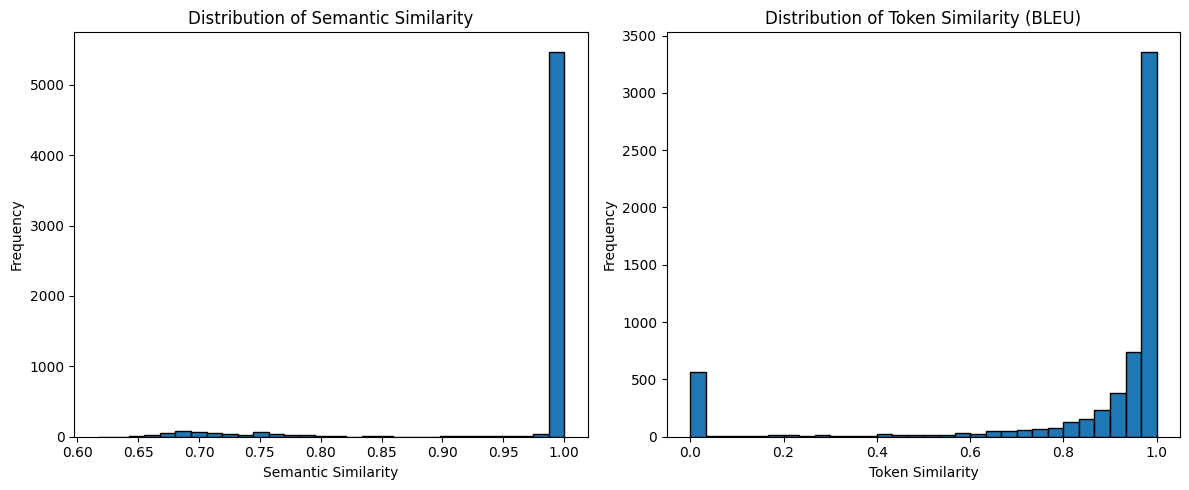

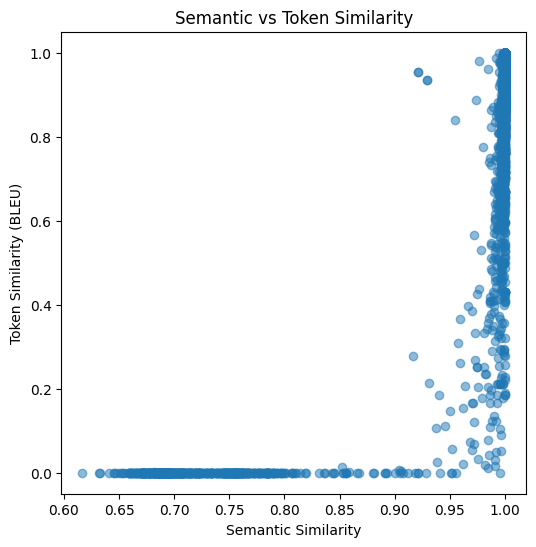

In [ ]:
import matplotlib.pyplot as plt

# Histograms for Semantic_Similarity and Token_Similarity
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.hist(df["Semantic_Similarity"], bins=30, edgecolor="black")
plt.title("Distribution of Semantic Similarity")
plt.xlabel("Semantic Similarity")
plt.ylabel("Frequency")

plt.subplot(1,2,2)
plt.hist(df["Token_Similarity"], bins=30, edgecolor="black")
plt.title("Distribution of Token Similarity (BLEU)")
plt.xlabel("Token Similarity")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

# Scatterplot: Semantic vs Token Similarity
plt.figure(figsize=(6,6))
plt.scatter(df["Semantic_Similarity"], df["Token_Similarity"], alpha=0.5)
plt.title("Semantic vs Token Similarity")
plt.xlabel("Semantic Similarity")
plt.ylabel("Token Similarity (BLEU)")
plt.show()


In [ ]:
# shapes / columns
print(df.shape)
print(df.columns.tolist())

# missing values
print(df[["Semantic_Similarity","Token_Similarity"]].isna().sum())

# value ranges
print(df["Semantic_Similarity"].describe())
print(df["Token_Similarity"].describe())


(6100, 19)
['Hash', 'Message', 'Filename', 'Source Before', 'Source Current', 'Diff', 'Fix Type', 'Rectified Message', 'MI_Before', 'MI_After', 'MI_Change', 'CC_Before', 'CC_After', 'CC_Change', 'LOC_Before', 'LOC_After', 'LOC_Change', 'Semantic_Similarity', 'Token_Similarity']
Semantic_Similarity    0
Token_Similarity       0
dtype: int64
count    6100.000000
mean        0.974438
std         0.079711
min         0.616823
25%         0.999371
50%         0.999967
75%         1.000000
max         1.000000
Name: Semantic_Similarity, dtype: float64
count    6100.000000
mean        0.842225
std         0.298163
min         0.000000
25%         0.888152
50%         0.974576
75%         0.993296
max         1.000000
Name: Token_Similarity, dtype: float64


In [ ]:
import pandas as pd
import os
from tqdm import tqdm

input_file = "/content/drive/MyDrive/STT_CSE/partd_ass3.csv"     # input from part d
output_file = "/content/drive/MyDrive/STT_CSE/parte_ass3.csv"    # output for part e

# Load input file
df = pd.read_csv(input_file)

# If resuming, load existing output
if os.path.exists(output_file):
    df_out = pd.read_csv(output_file)
    already_done = df_out["Semantic_class"].notna().sum()
    print(f" Resuming from row {already_done}")
else:
    df_out = df.copy()
    df_out["Semantic_class"] = None
    df_out["Token_class"] = None
    df_out["Classes_Agree"] = None
    already_done = 0

# Process with thresholds
for i in tqdm(range(already_done, len(df_out)), desc="Classifying"):
    semantic_val = df_out.at[i, "Semantic_Similarity"]
    token_val = df_out.at[i, "Token_Similarity"]

    # Semantic classification
    if semantic_val >= 0.80:
        df_out.at[i, "Semantic_class"] = "Minor"
    else:
        df_out.at[i, "Semantic_class"] = "Major"

    # Token classification
    if token_val >= 0.75:
        df_out.at[i, "Token_class"] = "Minor"
    else:
        df_out.at[i, "Token_class"] = "Major"

    # Agreement
    if df_out.at[i, "Semantic_class"] == df_out.at[i, "Token_class"]:
        df_out.at[i, "Classes_Agree"] = "YES"
    else:
        df_out.at[i, "Classes_Agree"] = "NO"

    # Save progress every 100 rows
    if i % 100 == 0:
        df_out.to_csv(output_file, index=False)

# Final save
df_out.to_csv(output_file, index=False)
print(f" Classification completed! Output saved at {output_file}")


Classifying: 100%|██████████| 6100/6100 [14:54<00:00,  6.82it/s]


 Classification completed! Output saved at /content/drive/MyDrive/STT_CSE/parte_ass3.csv


In [ ]:
df

,Hash,Message,Filename,Source Before,Source Current,Diff,Fix Type,Rectified Message,MI_Before,MI_After,...,CC_After,CC_Change,LOC_Before,LOC_After,LOC_Change,Semantic_Similarity,Token_Similarity,Semantic_class,Token_class,Classes_Agree
0,268676b42215080ca3a6be283082f3e02de4eb64,fix pip upload,publish_pip.sh,rm -rf dist hub_array.egg-info\npython3 setup....,rm -rf dist hub.egg-info\npython3 setup.py sdi...,"@@ -1,3 +1,3 @@\n-rm -rf dist hub_array.egg-in...",remove missing dist-info,remove missing dist-info in publish_pip.sh,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.998861,0.701688,Minor,Major,NO
1,11616dbf1a0fec14ead2cbe531059ae50f101f2c,bugfixes,interface.py,"from bbox import Bbox, chunknames, shade, Vec,...","from bbox import Bbox, chunknames, shade, Vec,...","@@ -44,7 +44,7 @@ class TensorInterface(object...",add missing docstrings,add missing docstrings in interface.py,61.701053,61.701053,...,18.0,0.0,123.0,123.0,0.0,1.000000,0.992576,Minor,Minor,YES
2,11616dbf1a0fec14ead2cbe531059ae50f101f2c,bugfixes,storage.py,import boto3\nimport botocore\nimport tenacity...,import boto3\nimport botocore\nimport tenacity...,"@@ -39,7 +39,7 @@ class S3(Storage):\n ...",add retry to s3_object_list,add retry to s3_object_list in storage.py,65.168767,65.168767,...,18.0,0.0,69.0,69.0,0.0,1.000000,0.932172,Minor,Minor,YES
3,031952c238e056341ac483f40c2c14633e4764ed,exception handling,docker-compose.yaml,version: '2'\n\nservices:\n hub:\n build:\...,version: '2'\n\nservices:\n test:\n build:...,"@@ -1,15 +1,14 @@\n version: '2'\n \n services...",add missing line after hub array,add missing line after hub array in docker-com...,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.999484,0.730411,Minor,Major,NO
4,031952c238e056341ac483f40c2c14633e4764ed,exception handling,exceptions.py,"\nclass OutOfBoundsError(Exception):\n """"""R...","\nclass OutOfBoundsError(Exception):\n """"""R...","@@ -1,4 +1,20 @@\n \n class OutOfBoundsError(E...",add missing docstring,add missing docstring in exceptions.py,100.000000,100.000000,...,5.0,4.0,4.0,20.0,16.0,0.975697,0.203262,Minor,Major,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6095,e3f11a8b5bd5f9b21dda3837db7fcde304e20a50,minor changes,chunk_engine.py,from collections import OrderedDict\nfrom deep...,from collections import OrderedDict\nfrom deep...,"@@ -838,26 +838,27 @@ class ChunkEngine:\n ...",add missing docstrings,add missing docstrings in chunk_engine.py,0.000000,0.000000,...,758.0,0.0,3444.0,3444.0,0.0,1.000000,0.998865,Minor,Minor,YES
6096,e3f11a8b5bd5f9b21dda3837db7fcde304e20a50,minor changes,test_indra_dataset.py,import deeplake\nimport numpy as np\nfrom deep...,import deeplake\nimport numpy as np\nfrom deep...,"@@ -17,7 +17,7 @@ def test_indexing(local_auth...",add tests for the new example,add tests for the new example in test_indra_da...,9.607790,9.607790,...,138.0,0.0,497.0,497.0,0.0,0.999996,0.991693,Minor,Minor,YES
6097,e3f11a8b5bd5f9b21dda3837db7fcde304e20a50,minor changes,exceptions.py,import requests\nimport numpy as np\nfrom typi...,import requests\nimport numpy as np\nfrom typi...,"@@ -1159,3 +1159,8 @@ class InvalidAuthContext...",add missing docstring,add missing docstring in exceptions.py,0.000000,0.000000,...,494.0,3.0,1161.0,1166.0,5.0,1.000000,0.996561,Minor,Minor,YES
6098,8ade86587d8a94a8d0f1372792d2150c9ddce761,Fixed readme links (#2975),README.md,"<img src=""https://static.scarf.sh/a.png?x-pxid...","<img src=""https://static.scarf.sh/a.png?x-pxid...","@@ -71,16 +71,16 @@ pip install deeplake\n \n ...",add missing docs,add missing docs in README.md,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.000000,0.996471,Minor,Minor,YES


In [ ]:
import pandas as pd



print("\n📊 Summary Counts:")

# Counts for Semantic
print("\nSemantic_class counts:")
print(df["Semantic_class"].value_counts())

# Counts for Token
print("\nToken_class counts:")
print(df["Token_class"].value_counts())

# Agreement counts
print("\nClasses_Agree counts:")
print(df["Classes_Agree"].value_counts())



📊 Summary Counts:

Semantic_class counts:
Semantic_class
Minor    5584
Major     516
Name: count, dtype: int64

Token_class counts:
Token_class
Minor    5105
Major     995
Name: count, dtype: int64

Classes_Agree counts:
Classes_Agree
YES    5621
NO      479
Name: count, dtype: int64


In [ ]:
import nbformat

filename = "/content/drive/MyDrive/Colab Notebooks/STT_CSE_Ass_3(2)"   # change if you renamed the file

with open(filename) as f:
    nb = nbformat.read(f, as_version=4)

if "widgets" in nb["metadata"] and "state" not in nb["metadata"]["widgets"]:
    nb["metadata"]["widgets"]["state"] = {}

fixed_file = filename.replace(".ipynb", "_fixed.ipynb")
with open(fixed_file, "w") as f:
    nbformat.write(nb, f)

print("✅ Fixed file saved as:", fixed_file)


✅ Fixed file saved as: /content/drive/MyDrive/Colab Notebooks/STT_CSE_Ass_3(2)


In [ ]:
import nbformat

filename = "/content/drive/MyDrive/Colab Notebooks/STT_CSE_Ass_3(2)"  # use your file name

with open(filename) as f:
    nb = nbformat.read(f, as_version=4)

print(nb["metadata"].get("widgets", "No widgets metadata"))


No widgets metadata


In [ ]:
import nbformat

filename = "/content/drive/MyDrive/Colab Notebooks/STT_CSE_Ass_3(2)"  # change if needed

# Read notebook
with open(filename) as f:
    nb = nbformat.read(f, as_version=4)

# Remove widgets metadata entirely
if "widgets" in nb["metadata"]:
    del nb["metadata"]["widgets"]

# Save cleaned version
fixed_file = filename.replace(".ipynb", "_fixed.ipynb")
with open(fixed_file, "w") as f:
    nbformat.write(nb, f)

print("✅ Cleaned notebook saved as:", fixed_file)


✅ Cleaned notebook saved as: /content/drive/MyDrive/Colab Notebooks/STT_CSE_Ass_3(2)
